# Advanced Interface features

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install gradio

# Using state to persist data
Gradio supports `session state`, where data persists across multiple submits within a page load. Session state is useful for building demos of, for example, chatbots where you want to persist data as the user interacts with the model. Note that session state does not share data between different users of your model.

To store data in a session state, you need to do three things:

1. Pass in an extra parameter into your function, which represents the state of the interface.
2. At the end of the function, return the updated value of the state as an extra return value.
3. Add the ‘state’ input and ‘state’ output components when creating your Interface.

In [ ]:
import random

import gradio as gr


def chat(message, history):
    history = history or []
    if message.startswith("How many"):
        response = random.randint(1, 10)
    elif message.startswith("How"):
        response = random.choice(["Great", "Good", "Okay", "Bad"])
    elif message.startswith("Where"):
        response = random.choice(["Here", "There", "Somewhere"])
    else:
        response = "I don't know"
    history.append((message, response))
    return history, history


iface = gr.Interface(
    chat,
    ["text", "state"],
    ["chatbot", "state"],
    allow_screenshot=False,
    allow_flagging="never",
)
iface.launch()

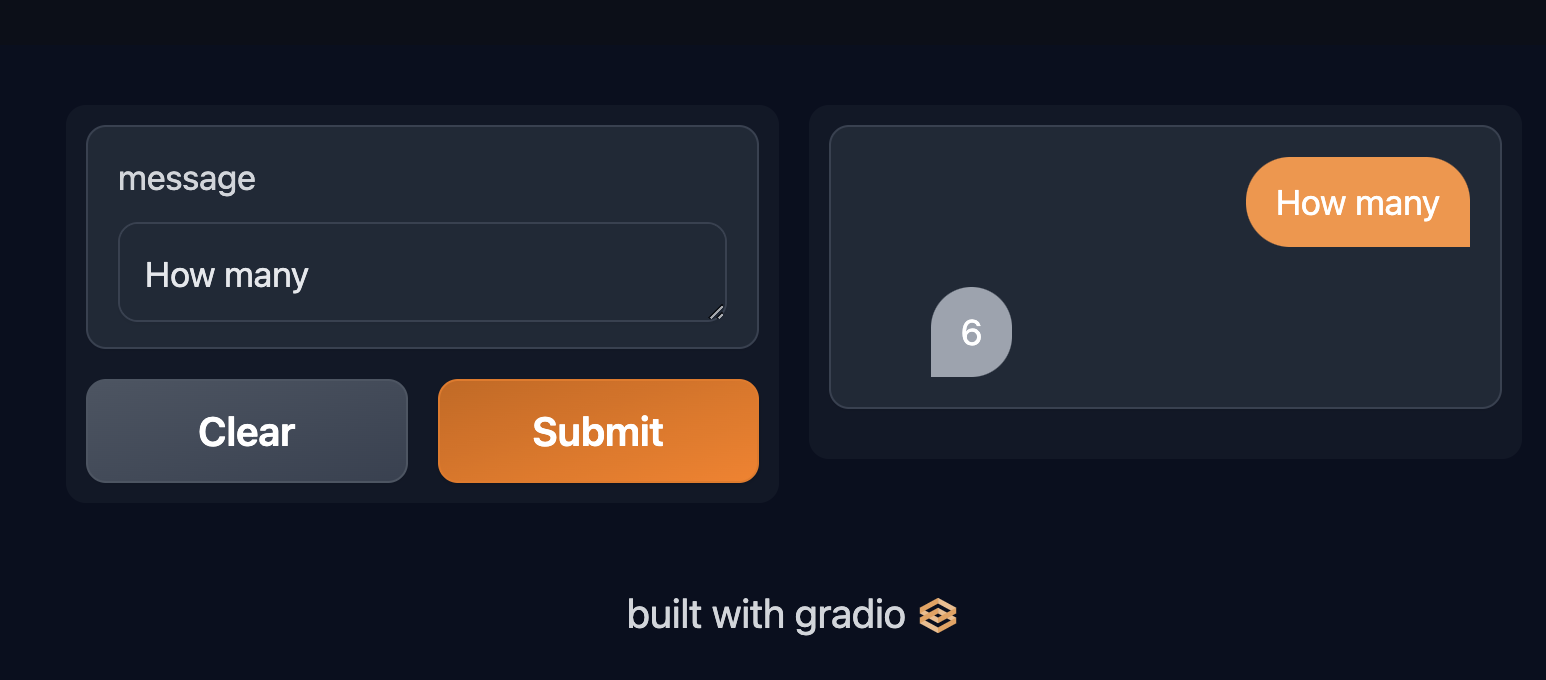

# Using interpretation to understand predictions
Most machine learning models are black boxes and the internal logic of the function is hidden from the end user. To encourage transparency, we’ve made it very easy to add interpretation to your model by simply setting the `interpretation keyword` in the Interface class to default.

This allows your users to understand what parts of the input are responsible for the output. Take a look at the simple interface below which shows an image classifier that also includes interpretation:

In [ ]:
import requests
import tensorflow as tf

import gradio as gr

inception_net = tf.keras.applications.MobileNetV2()  # load the model

# Download human-readable labels for ImageNet.
response = requests.get("https://git.io/JJkYN")
labels = response.text.split("\n")


def classify_image(inp):
    inp = inp.reshape((-1, 224, 224, 3))
    inp = tf.keras.applications.mobilenet_v2.preprocess_input(inp)
    prediction = inception_net.predict(inp).flatten()
    return {labels[i]: float(prediction[i]) for i in range(1000)}


image = gr.Image(shape=(224, 224))
label = gr.Label(num_top_classes=3)

title = "Gradio Image Classifiction + Interpretation Example"
gr.Interface(
    fn=classify_image, inputs=image, outputs=label, interpretation="default", title=title
).launch()

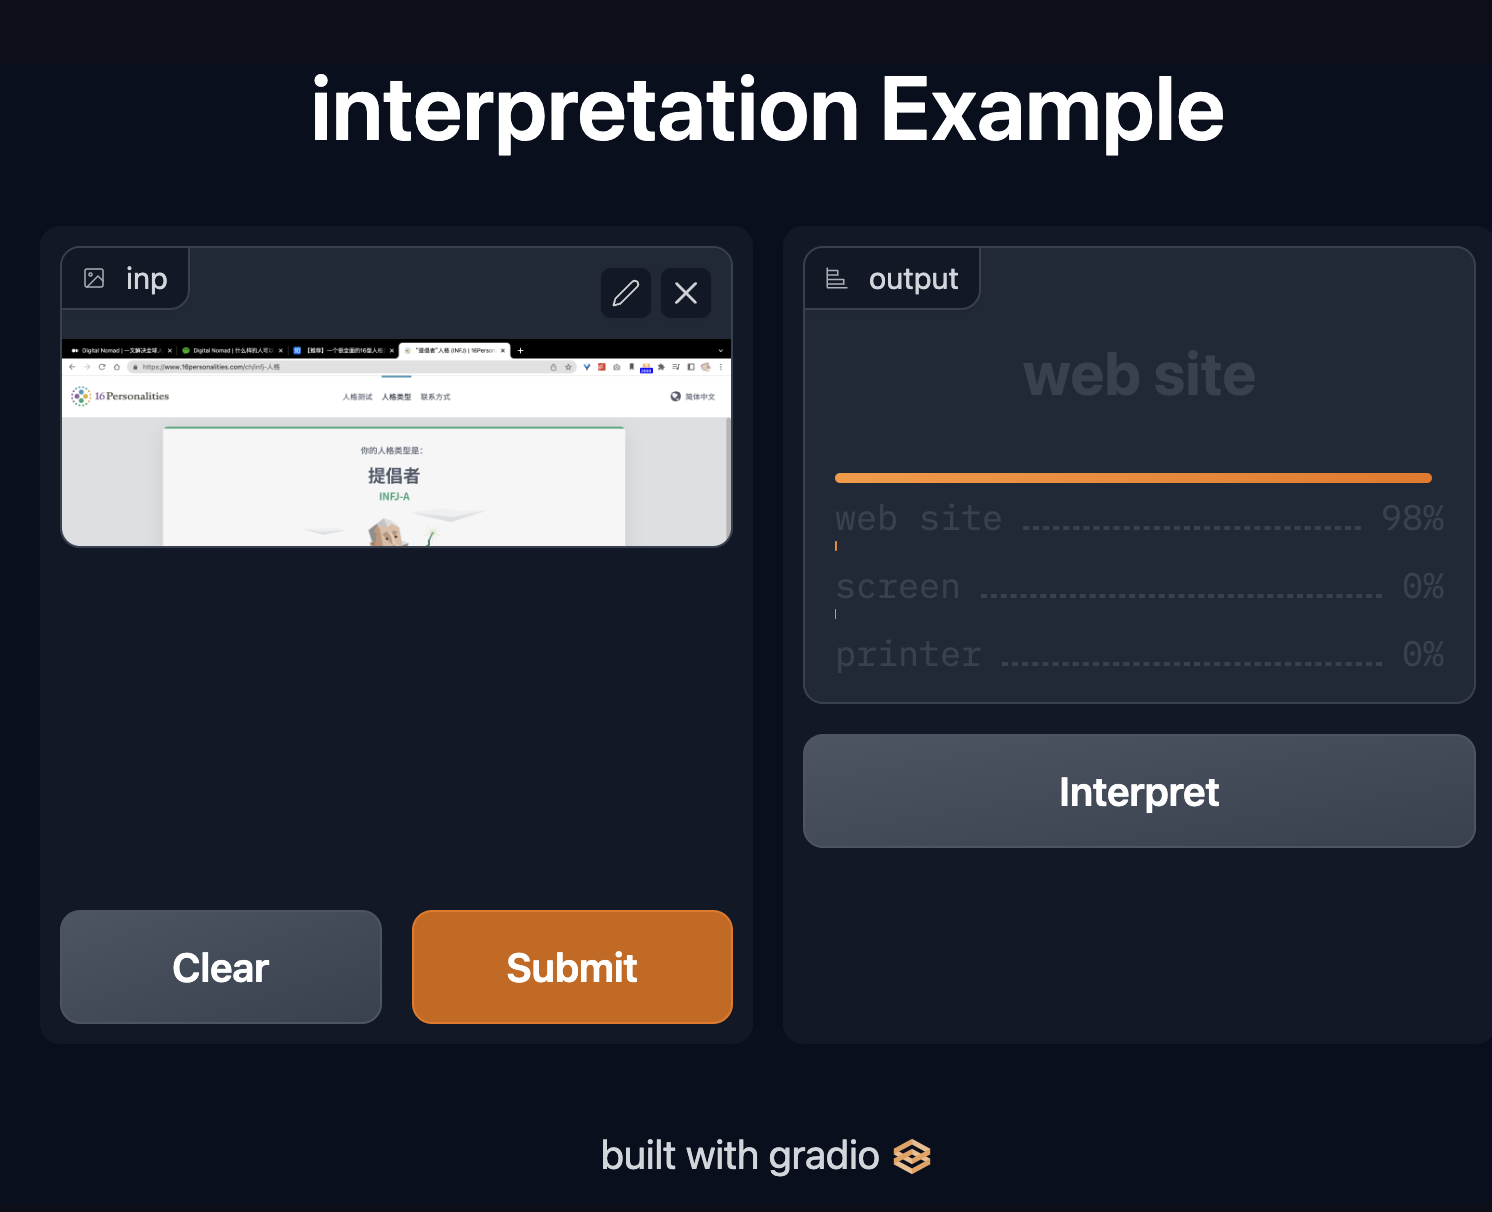

Besides the default interpretation method Gradio provides, you can also specify shap for the `interpretation` parameter and set the `num_shap `parameter. This uses `Shapley-based interpretation`, which you can read more about [here](https://christophm.github.io/interpretable-ml-book/shap.html). Lastly, you can also pass in your own interpretation function into the interpretation parameter. See an example in Gradio’s getting started page [here](https://gradio.app/getting_started/).

This wraps up our deep dive into the Interface class of Gradio. As we’ve seen, this class makes it simple to create machine learning demos in a few lines of Python code. However, sometimes you’ll want to customise your demo by changing the layout or chaining multiple prediction functions together. Wouldn’t it be nice if we could somehow split the Interface into customizable “blocks”? Fortunately, there is! That’s the topic of the final section.